In [12]:
# %% Import modules
import torch
import einops

from transformer_lens import HookedTransformer, FactoredMatrix

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from load_data import get_prompts_t

In [2]:
# Global settings and variables
sns.set()
torch.set_grad_enabled(False)
device = "cpu"

In [3]:
# Setup model & load data
model = HookedTransformer.from_pretrained('gelu-4l')
model.cfg.use_attn_result = True
model.to(device);

Loaded pretrained model gelu-4l into HookedTransformer
Moving model to device:  cpu


In [19]:
n_text_prompts = 240
n_code_prompts = 60

prompts = get_prompts_t(
    n_text_prompts=n_text_prompts,
    n_code_prompts=n_code_prompts
)

Loading 240 prompts from c4-tokenized-2b...


100%|██████████| 240/240 [00:02<00:00, 101.95it/s]


Loading 60 prompts from code-tokenized...


100%|██████████| 60/60 [00:01<00:00, 43.77it/s]


For each prompt get the direct logit attribution for the next token

### Find DLA for the output directions of the following nodes
- For writer head
- For each cleaner head individually
- For the sum of all cleaner heads [2:]

### For all sequence positions
- For all sequence positions
    - Hyperparameter

In [60]:
a = torch.arange(18).reshape(3,2,3)
print(a.shape)
res = einops.rearrange(
    a,
    "batch pos dm -> (batch pos) dm"
)
print(res.shape)

torch.Size([3, 2, 3])
torch.Size([6, 3])


In [79]:
def get_dla(model, prompt_token_ids, start_pos=0):
    # Get activations
    _, cache = model.run_with_cache(
        prompt_token_ids,
        names_filter=lambda name: (
            name == "blocks.0.attn.hook_result"
            or name == "blocks.2.ln1.hook_scale"
            or name == "blocks.2.attn.hook_result"
            or name == "ln_final.hook_scale"
        ),
    )

    writer_output = cache["blocks.0.attn.hook_result"][:, :, 2, :]  # (batch, pos, d_model)
    writer_block2_ln = (writer_output - writer_output.mean(dim=-1, keepdim=True)) / cache["blocks.2.ln1.hook_scale"]
    cleanup_head_idx = [2,3,4,5,6,7]
    cleaner_output = einops.reduce(
        cache["blocks.2.attn.hook_result"][:, :, cleanup_head_idx, :],
        "batch pos head d_model -> batch pos d_model",
        "sum",
    )

    # Get V-composition of L0H2 to L2HX
    # Use six heads only
    L2HX_W_OV = einops.einsum(
        model.W_V[2, 2:],
        model.W_O[2, 2:],
        "head d_model_V d_head, head d_head d_model_O -> head d_model_V d_model_O"
    )

    v_comp = einops.einsum(
        writer_block2_ln, 
        L2HX_W_OV,
        "batch pos d_model_V, head d_model_V d_model_O -> batch pos d_model_O"
    )

    # Apply final layer norm scale
    scale = cache["ln_final.hook_scale"]
    apply_ln = lambda x: (x - x.mean(dim=-1, keepdim=True)) / scale
    writer_ln = apply_ln(writer_output)[:, start_pos:-1, :] # There's no correct prediction for the last token
    cleaner_ln = apply_ln(cleaner_output)[:, start_pos:-1, :]
    v_comp_ln = apply_ln(v_comp)[:, start_pos:-1, :]

    # Retrieve correct next tokens from prompt
    correct_token_ids = prompt_token_ids[:, start_pos+1:] # (batch pos)

    # Flatten batch dim 
    # (batch has to be flattened anyways for scatterplot, flattening now bc accessing model.W_U with single flattened token array is easier)
    writer_ln = einops.rearrange(
        writer_ln,
        "batch pos d_model -> (batch pos) d_model"
    )
    cleaner_ln = einops.rearrange(
        cleaner_ln,
        "batch pos d_model -> (batch pos) d_model"
    )
    v_comp_ln = einops.rearrange(
        v_comp_ln,
        "batch pos d_model -> (batch pos) d_model"
    )
    correct_token_ids = einops.rearrange(
        correct_token_ids,
        "batch pos -> (batch pos)"
    )

    # Dot prod with unembed vector corresponding to correct next token
    correct_logit_directions = model.W_U[:, correct_token_ids] # (d_model pos)

    writer_dla = einops.einsum(
        writer_ln, # last token has correct prediction in prompt
        correct_logit_directions,
        "pos d_model, d_model pos-> pos"
    )
    cleaner_dla = einops.einsum(
        cleaner_ln,
        correct_logit_directions,
        "pos d_model, d_model pos -> pos"
    )
    v_comp_dla = einops.einsum(
        v_comp_ln,
        correct_logit_directions,
        "pos d_model, d_model pos -> pos"
    )

    return writer_dla, cleaner_dla, v_comp_dla

## Plots

In [80]:
n_prompts = 10
start_pos = 500

writer_dla, cleaner_dla, v_comp_dla = get_dla(model, prompts[:n_prompts], start_pos=start_pos)

### DLA of writer vs DLA of (sum of cleaners)

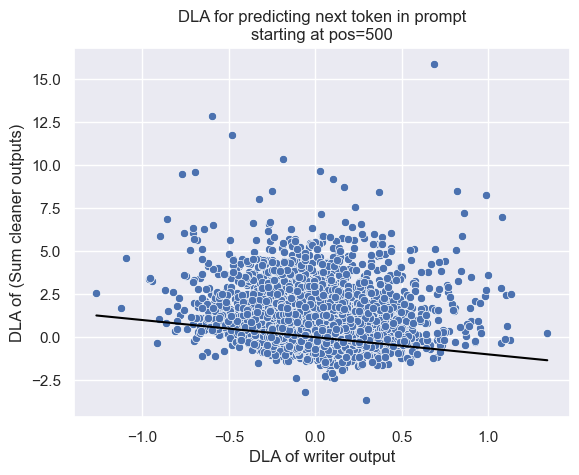

In [78]:
sns.scatterplot(x=writer_dla, y=cleaner_dla)

line = torch.linspace(start=min(writer_dla), end=max(writer_dla), steps=20)
sns.lineplot(x=line, y=-line, color='black')

plt.title(f"DLA for predicting next token in prompt\nstarting at pos={start_pos}")
plt.xlabel("DLA of writer output")
plt.ylabel("DLA of (Sum cleaner outputs)");

### DLA of writer vs DLA of V-composition (writer->cleaner)

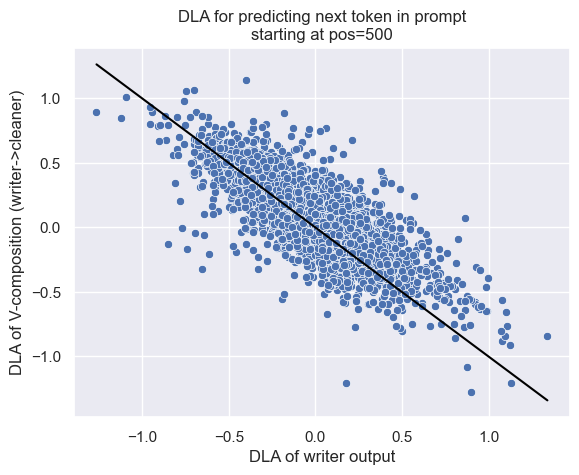

In [81]:
sns.scatterplot(x=writer_dla, y=v_comp_dla)

line = torch.linspace(start=min(writer_dla), end=max(writer_dla), steps=20)
sns.lineplot(x=line, y=-line, color='black')

plt.title(f"DLA for predicting next token in prompt\nstarting at pos={start_pos}")
plt.xlabel("DLA of writer output")
plt.ylabel("DLA of V-composition (writer->cleaner)");